In [100]:
import requests
from pprint import pprint
import altair as alt
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt  # To visualize
import numpy as np
import pandas as pd

In [79]:
NOTION_URL = 'https://api.notion.com/v1/databases/'
TABLE_ID = "12e01bfc60a84007aa7d2d34293e123d"
API_KEY = open("notion_key", "r").read()

def get_notion_database(url, table_id, api_key, responses = None, start_cursor = None):
    """
    Get the data from Notion database
    """
    
    headers = {
        'Authorization': 'Bearer ' + api_key,
        'Notion-Version': '2022-02-22',
        'Content-Type': 'application/json'
    }
    payload = {}
    if start_cursor:
        payload['start_cursor'] = start_cursor

    p_url = url + table_id + '/query'
    response = requests.post(p_url, json=payload, headers=headers)
    responses.append(response.json())

    if 'has_more' in response.json() and response.json()['has_more'] == True:
        next_page_token = response.json()['next_cursor']
        get_notion_database(url, table_id, api_key, responses, next_page_token)

    return responses

db = get_notion_database(NOTION_URL, TABLE_ID, API_KEY, [])
results = [item for sublist in db for item in sublist['results']]

In [164]:
def get_year(entry):
    if len(entry['properties']['year']['rich_text']) < 1: return None
    else: return int(entry['properties']['year']['rich_text'][0]['plain_text'])

def get_num_samples(entry):
    if len(entry['properties']['dataset size']['rich_text']) < 1: return 0
    else: return eval(entry['properties']['dataset size']['rich_text'][0]['plain_text'])

def get_paper_name(entry):
    return entry['properties']['Name']['title'][0]['plain_text']

def get_dataset_tags(entry):
    if len(entry['properties']['Dataset tag']['multi_select']) < 0: return []
    else: return [x['name'] for x in entry['properties']['Dataset tag']['multi_select']]

def get_graph_features(entry):
    if len(entry['properties']['Graph feature']['multi_select']) < 0: return []
    else: return [x['name'] for x in entry['properties']['Graph feature']['multi_select']]

def get_paper_type(entry):
    if len(entry['properties']['paper type']['multi_select']) < 0: return []
    else: return [x['name'] for x in entry['properties']['paper type']['multi_select']]

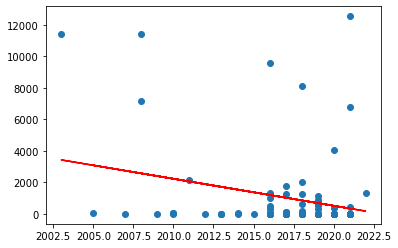

In [126]:
# how did number of samples grow over time?
years = []
samples = []

for i, result in enumerate(results):
    if get_year(result) is None: continue
    if 'algorithm' not in get_paper_type(result) and 'comparison' not in get_paper_type(result): continue
    # if get_num_samples(result) > 10000: continue # remove this?

    years.append(get_year(result))
    samples.append(get_num_samples(result))

tmpx = np.array(years).reshape(-1, 1)
tmpy = np.array(samples).reshape(-1, 1)

linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(tmpx, tmpy)  # perform linear regression
Y_pred = linear_regressor.predict(tmpx)  # make predictions

plt.scatter(tmpx, tmpy)
plt.plot(tmpx, Y_pred, color='red')
plt.show()

In [160]:
def get_papers_with_sample_size_in_range(r = [0, 100]):
    """
    Get all papers with sample size in range
    """
    return [x for x in results if get_num_samples(x) <= r[1] and get_num_samples(x) >= r[0] and get_year(x) is not None and ('algorithm' in get_paper_type(x) or 'comparison' in get_paper_type(x))]

ranges = [[0, 0], [1, 10], [10, 100], [100, 1000], [1000, 10000], [10000, 100000]]
for r in ranges:
    print(r, len(get_papers_with_sample_size_in_range(r)))

source = pd.DataFrame({
    'number of samples': [str(r[0]) + " to " + str(r[1]) for r in ranges],
    'number of papers': [len(get_papers_with_sample_size_in_range(r)) for r in ranges]
})

threshold = 100
alt.Chart(source).mark_bar(size=50).encode(
    x='number of samples',
    y='number of papers',
    color=alt.Color('number of samples', scale = alt.Scale(scheme='cividis')),
).properties(
    width=400,
    title='Number of papers with sample size in range'
)

[0, 0] 24
[1, 10] 21
[10, 100] 15
[100, 1000] 13
[1000, 10000] 14
[10000, 100000] 3


alt.Chart(...)

In [104]:
tags = {}

for result in results:
    if get_year(result) is None: continue

    for tag in get_dataset_tags(result):
        if tag not in tags:
            tags[tag] = 0
        tags[tag] += 1

tags2 = {key:val for key, val in tags.items() if val > 1 and key != 'none'}

source = pd.DataFrame({
    'a': tags2.keys(),
    'b': tags2.values()
})

alt.Chart(source).mark_bar().encode(
    x='a',
    y='b'
)

alt.Chart(...)

In [187]:
colors = ["nsl_red", "nsl_blue", "nsl_green", "nsl_yellow", "nsl_orange", "nsl_purple", "nsl_brown", "nsl_pink", "nsl_gray"]
colors_dark = ["nsd_red", "nsd_blue", "nsd_green", "nsd_yellow", "nsd_orange", "nsd_purple", "nsd_brown", "nsd_pink", "nsd_gray"]

featuredict = {}

for i, element in enumerate(results):

    for el in get_dataset_tags(element):
        if el not in featuredict:
            featuredict[el] = {}

        if len(get_graph_features(element)) == 0:
            if 'generic' not in featuredict[el]:
                featuredict[el]['generic'] = []
            featuredict[el]['generic'].append("a")

        for feature in get_graph_features(element):
            if feature not in featuredict[el]:
                featuredict[el][feature] = []
            featuredict[el][feature].append("a")

tags_filtered = tags2
# pprint(featuredict)

for i, d in enumerate(featuredict):
    if d not in tags_filtered:
        continue
    toprint = "\colortext{" + colors[i%len(colors)] + "}{" + d + "} & "
    for j, f in enumerate(featuredict[d]):
        toprint += "\colortext{" + colors_dark[j%len(colors_dark)] + "}{" + f + "}"
    toprint += "\\\\ \hline"
    print(toprint)


\colortext{nsl_blue}{custom (random)} & \colortext{nsd_red}{generic}\colortext{nsd_blue}{temporal event sequence}\colortext{nsd_green}{Layered graphs}\colortext{nsd_yellow}{many layers}\colortext{nsd_orange}{large}\colortext{nsd_purple}{Directed graphs}\colortext{nsd_brown}{hypergraphs}\colortext{nsd_pink}{spatial}\colortext{nsd_gray}{linear layout}\colortext{nsd_red}{two-level crossing minimiazation}\\ \hline
\colortext{nsl_purple}{Rome-Lib} & \colortext{nsd_red}{generic}\colortext{nsd_blue}{ortho-radial}\colortext{nsd_green}{ortho}\colortext{nsd_yellow}{Layered graphs}\colortext{nsd_orange}{many layers}\colortext{nsd_purple}{groups}\colortext{nsd_brown}{Compound graphs}\\ \hline
\colortext{nsl_brown}{North Lib} & \colortext{nsd_red}{generic}\colortext{nsd_blue}{Layered graphs}\colortext{nsd_green}{many layers}\colortext{nsd_yellow}{large}\colortext{nsd_orange}{Directed graphs}\colortext{nsd_purple}{hierarchical}\colortext{nsd_brown}{two-level crossing minimiazation}\\ \hline
\colorte